# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

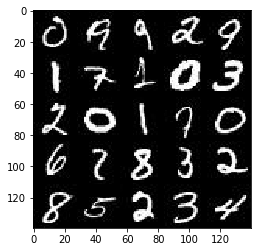

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

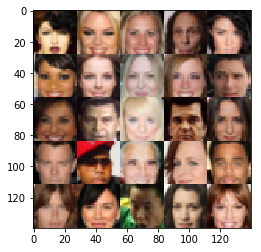

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
         
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same',
                              kernel_initializer = tf.random_normal_initializer(stddev=0.05))
        x1 = tf.maximum(0.2 * x1, x1)
    
        x2 = tf.layers.conv2d(x1, 256, 5, strides=2, padding='same',
                              kernel_initializer = tf.random_normal_initializer(stddev=0.05))
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(0.2 * x2, x2)
       
        x3 = tf.layers.conv2d(x2, 512, 5, strides=2, padding='same',
                              kernel_initializer = tf.random_normal_initializer(stddev=0.05))
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(0.2 * x3, x3)
        
        flat = tf.reshape(x3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator',reuse = not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.2 * x1, x1)
       
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',
                                        kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2 * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                                        kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.2 * x3, x3)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same',
                                        kernel_initializer =tf.random_normal_initializer(stddev=0.05))
         
        out = tf.tanh(logits)     
  
    return out 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    with tf.variable_scope(tf.get_variable_scope(), reuse=False) as scope:
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height,image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        steps = 0
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr:learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 50, input_z, image_channels, data_image_mode)
                        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.8795... Generator Loss: 0.7133
Epoch 1/2... Discriminator Loss: 0.3686... Generator Loss: 3.9802
Epoch 1/2... Discriminator Loss: 9.8332... Generator Loss: 18.3693
Epoch 1/2... Discriminator Loss: 2.8549... Generator Loss: 0.2081
Epoch 1/2... Discriminator Loss: 1.6315... Generator Loss: 3.4811
Epoch 1/2... Discriminator Loss: 1.2419... Generator Loss: 0.8395
Epoch 1/2... Discriminator Loss: 1.2234... Generator Loss: 0.8505
Epoch 1/2... Discriminator Loss: 1.9495... Generator Loss: 0.3115
Epoch 1/2... Discriminator Loss: 1.3930... Generator Loss: 1.8524
Epoch 1/2... Discriminator Loss: 1.3487... Generator Loss: 0.6790


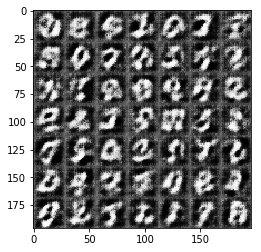

Epoch 1/2... Discriminator Loss: 1.3771... Generator Loss: 1.4411
Epoch 1/2... Discriminator Loss: 1.4152... Generator Loss: 1.9540
Epoch 1/2... Discriminator Loss: 1.4847... Generator Loss: 1.6462
Epoch 1/2... Discriminator Loss: 1.3843... Generator Loss: 0.5756
Epoch 1/2... Discriminator Loss: 1.3573... Generator Loss: 0.7800
Epoch 1/2... Discriminator Loss: 1.7446... Generator Loss: 0.3722
Epoch 1/2... Discriminator Loss: 1.4999... Generator Loss: 0.4820
Epoch 1/2... Discriminator Loss: 1.3219... Generator Loss: 1.6088
Epoch 1/2... Discriminator Loss: 1.2863... Generator Loss: 0.6095
Epoch 1/2... Discriminator Loss: 1.1397... Generator Loss: 1.2155


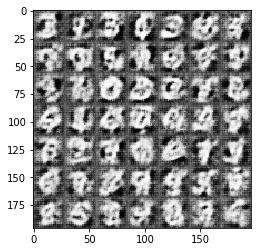

Epoch 1/2... Discriminator Loss: 1.1541... Generator Loss: 1.8494
Epoch 1/2... Discriminator Loss: 1.0751... Generator Loss: 0.8967
Epoch 1/2... Discriminator Loss: 1.6384... Generator Loss: 2.5404
Epoch 1/2... Discriminator Loss: 1.0642... Generator Loss: 0.9318
Epoch 1/2... Discriminator Loss: 1.0589... Generator Loss: 2.1398
Epoch 1/2... Discriminator Loss: 1.0034... Generator Loss: 0.9716
Epoch 1/2... Discriminator Loss: 1.2078... Generator Loss: 0.6548
Epoch 1/2... Discriminator Loss: 1.7101... Generator Loss: 0.3502
Epoch 1/2... Discriminator Loss: 1.1636... Generator Loss: 0.7444
Epoch 1/2... Discriminator Loss: 1.7690... Generator Loss: 0.4256


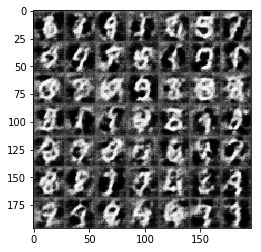

Epoch 1/2... Discriminator Loss: 1.1358... Generator Loss: 0.7589
Epoch 1/2... Discriminator Loss: 1.3561... Generator Loss: 0.5301
Epoch 1/2... Discriminator Loss: 1.3580... Generator Loss: 1.7470
Epoch 1/2... Discriminator Loss: 1.4633... Generator Loss: 0.4709
Epoch 1/2... Discriminator Loss: 1.3824... Generator Loss: 0.6257
Epoch 1/2... Discriminator Loss: 1.2371... Generator Loss: 0.7206
Epoch 1/2... Discriminator Loss: 1.2197... Generator Loss: 0.8585
Epoch 1/2... Discriminator Loss: 1.0320... Generator Loss: 1.0508
Epoch 1/2... Discriminator Loss: 1.2116... Generator Loss: 0.7189
Epoch 1/2... Discriminator Loss: 1.2143... Generator Loss: 0.7534


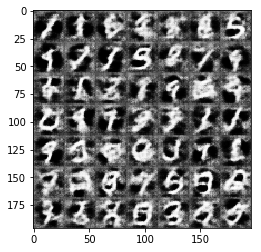

Epoch 1/2... Discriminator Loss: 1.0345... Generator Loss: 1.1082
Epoch 1/2... Discriminator Loss: 1.4720... Generator Loss: 2.0965
Epoch 1/2... Discriminator Loss: 1.4224... Generator Loss: 2.2884
Epoch 1/2... Discriminator Loss: 1.4928... Generator Loss: 0.5090
Epoch 1/2... Discriminator Loss: 1.1604... Generator Loss: 1.5990
Epoch 1/2... Discriminator Loss: 1.5221... Generator Loss: 1.9588
Epoch 1/2... Discriminator Loss: 1.1991... Generator Loss: 0.8074
Epoch 1/2... Discriminator Loss: 1.2882... Generator Loss: 0.5955
Epoch 1/2... Discriminator Loss: 1.5561... Generator Loss: 0.4163
Epoch 1/2... Discriminator Loss: 1.5993... Generator Loss: 0.4606


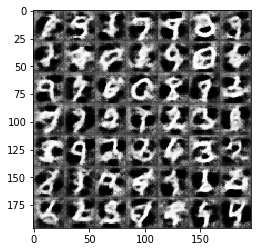

Epoch 1/2... Discriminator Loss: 1.1508... Generator Loss: 0.8391
Epoch 1/2... Discriminator Loss: 1.6359... Generator Loss: 3.1872
Epoch 1/2... Discriminator Loss: 1.4486... Generator Loss: 0.4974
Epoch 1/2... Discriminator Loss: 1.0488... Generator Loss: 0.9533
Epoch 1/2... Discriminator Loss: 1.1404... Generator Loss: 1.0807
Epoch 1/2... Discriminator Loss: 1.2017... Generator Loss: 0.8639
Epoch 1/2... Discriminator Loss: 1.0145... Generator Loss: 1.1461
Epoch 1/2... Discriminator Loss: 1.5150... Generator Loss: 0.5166
Epoch 1/2... Discriminator Loss: 1.4135... Generator Loss: 0.5059
Epoch 1/2... Discriminator Loss: 1.2048... Generator Loss: 0.6894


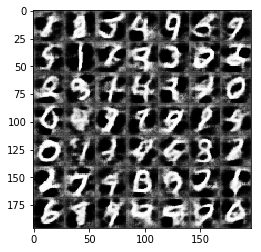

Epoch 1/2... Discriminator Loss: 1.1820... Generator Loss: 0.8411
Epoch 1/2... Discriminator Loss: 1.2794... Generator Loss: 0.5640
Epoch 1/2... Discriminator Loss: 1.0706... Generator Loss: 1.7394
Epoch 1/2... Discriminator Loss: 1.4068... Generator Loss: 0.4904
Epoch 1/2... Discriminator Loss: 1.4092... Generator Loss: 0.5119
Epoch 1/2... Discriminator Loss: 0.9967... Generator Loss: 1.2334
Epoch 1/2... Discriminator Loss: 1.1788... Generator Loss: 1.7712
Epoch 1/2... Discriminator Loss: 1.6355... Generator Loss: 0.3902
Epoch 1/2... Discriminator Loss: 1.1250... Generator Loss: 0.8898
Epoch 1/2... Discriminator Loss: 0.9673... Generator Loss: 1.2733


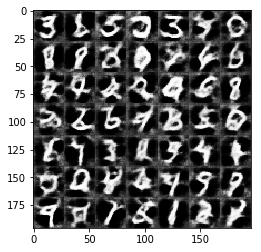

Epoch 1/2... Discriminator Loss: 1.0920... Generator Loss: 0.8317
Epoch 1/2... Discriminator Loss: 1.0692... Generator Loss: 1.4606
Epoch 1/2... Discriminator Loss: 1.2941... Generator Loss: 1.4168
Epoch 1/2... Discriminator Loss: 1.1612... Generator Loss: 1.3161
Epoch 1/2... Discriminator Loss: 1.0798... Generator Loss: 1.0814
Epoch 1/2... Discriminator Loss: 1.1207... Generator Loss: 0.8146
Epoch 1/2... Discriminator Loss: 1.0656... Generator Loss: 1.4079
Epoch 1/2... Discriminator Loss: 1.2810... Generator Loss: 0.6375
Epoch 1/2... Discriminator Loss: 1.0937... Generator Loss: 0.9021
Epoch 1/2... Discriminator Loss: 1.1678... Generator Loss: 0.6887


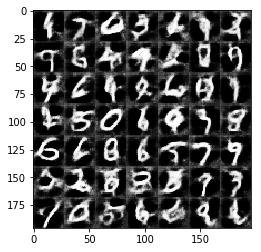

Epoch 1/2... Discriminator Loss: 0.9493... Generator Loss: 1.3619
Epoch 1/2... Discriminator Loss: 1.1510... Generator Loss: 2.1751
Epoch 1/2... Discriminator Loss: 1.0094... Generator Loss: 1.7614
Epoch 1/2... Discriminator Loss: 1.7388... Generator Loss: 0.3677
Epoch 1/2... Discriminator Loss: 1.1198... Generator Loss: 0.9837
Epoch 1/2... Discriminator Loss: 1.5724... Generator Loss: 0.4384
Epoch 1/2... Discriminator Loss: 1.2929... Generator Loss: 0.5890
Epoch 1/2... Discriminator Loss: 0.8711... Generator Loss: 1.4543
Epoch 1/2... Discriminator Loss: 1.0390... Generator Loss: 1.2610
Epoch 1/2... Discriminator Loss: 1.0425... Generator Loss: 1.4744


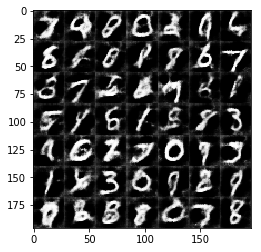

Epoch 1/2... Discriminator Loss: 1.3464... Generator Loss: 0.5867
Epoch 1/2... Discriminator Loss: 0.9702... Generator Loss: 1.6387
Epoch 1/2... Discriminator Loss: 0.9407... Generator Loss: 1.4275
Epoch 2/2... Discriminator Loss: 0.9164... Generator Loss: 1.0894
Epoch 2/2... Discriminator Loss: 1.2141... Generator Loss: 0.6857
Epoch 2/2... Discriminator Loss: 0.9842... Generator Loss: 1.3706
Epoch 2/2... Discriminator Loss: 1.0495... Generator Loss: 0.8489
Epoch 2/2... Discriminator Loss: 1.9581... Generator Loss: 3.0851
Epoch 2/2... Discriminator Loss: 1.0928... Generator Loss: 1.2310
Epoch 2/2... Discriminator Loss: 1.2178... Generator Loss: 0.6406


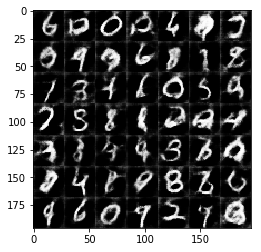

Epoch 2/2... Discriminator Loss: 0.8749... Generator Loss: 1.1799
Epoch 2/2... Discriminator Loss: 0.9463... Generator Loss: 1.5511
Epoch 2/2... Discriminator Loss: 2.3505... Generator Loss: 0.1957
Epoch 2/2... Discriminator Loss: 1.0455... Generator Loss: 1.1696
Epoch 2/2... Discriminator Loss: 0.9474... Generator Loss: 1.1227
Epoch 2/2... Discriminator Loss: 1.1218... Generator Loss: 0.8262
Epoch 2/2... Discriminator Loss: 1.1224... Generator Loss: 0.8157
Epoch 2/2... Discriminator Loss: 1.0958... Generator Loss: 0.7579
Epoch 2/2... Discriminator Loss: 0.8880... Generator Loss: 1.4606
Epoch 2/2... Discriminator Loss: 1.6957... Generator Loss: 0.4039


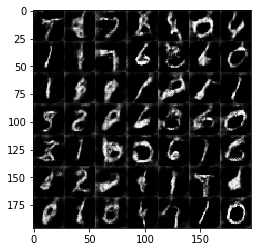

Epoch 2/2... Discriminator Loss: 0.9846... Generator Loss: 1.3948
Epoch 2/2... Discriminator Loss: 1.0755... Generator Loss: 0.9600
Epoch 2/2... Discriminator Loss: 1.1686... Generator Loss: 2.0843
Epoch 2/2... Discriminator Loss: 1.1187... Generator Loss: 0.7455
Epoch 2/2... Discriminator Loss: 1.2348... Generator Loss: 0.6373
Epoch 2/2... Discriminator Loss: 1.1047... Generator Loss: 0.9403
Epoch 2/2... Discriminator Loss: 1.0202... Generator Loss: 1.4707
Epoch 2/2... Discriminator Loss: 1.6096... Generator Loss: 0.4282
Epoch 2/2... Discriminator Loss: 1.3097... Generator Loss: 0.5975
Epoch 2/2... Discriminator Loss: 1.0406... Generator Loss: 0.9655


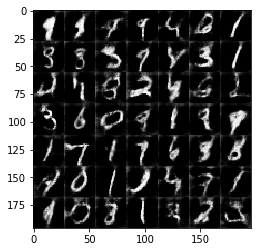

Epoch 2/2... Discriminator Loss: 0.9859... Generator Loss: 0.9780
Epoch 2/2... Discriminator Loss: 0.9528... Generator Loss: 1.2103
Epoch 2/2... Discriminator Loss: 1.2094... Generator Loss: 0.6384
Epoch 2/2... Discriminator Loss: 1.2433... Generator Loss: 0.6259
Epoch 2/2... Discriminator Loss: 0.9826... Generator Loss: 2.0371
Epoch 2/2... Discriminator Loss: 1.2613... Generator Loss: 0.6563
Epoch 2/2... Discriminator Loss: 1.6365... Generator Loss: 0.4527
Epoch 2/2... Discriminator Loss: 1.0075... Generator Loss: 1.6187
Epoch 2/2... Discriminator Loss: 1.1189... Generator Loss: 0.7801
Epoch 2/2... Discriminator Loss: 1.0026... Generator Loss: 1.1704


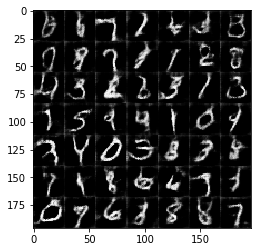

Epoch 2/2... Discriminator Loss: 1.0410... Generator Loss: 1.5931
Epoch 2/2... Discriminator Loss: 1.3573... Generator Loss: 0.5364
Epoch 2/2... Discriminator Loss: 1.0862... Generator Loss: 0.8022
Epoch 2/2... Discriminator Loss: 1.4537... Generator Loss: 0.4701
Epoch 2/2... Discriminator Loss: 0.8600... Generator Loss: 1.4120
Epoch 2/2... Discriminator Loss: 1.2313... Generator Loss: 2.1282
Epoch 2/2... Discriminator Loss: 1.2368... Generator Loss: 2.0944
Epoch 2/2... Discriminator Loss: 1.0644... Generator Loss: 0.8083
Epoch 2/2... Discriminator Loss: 0.9872... Generator Loss: 1.4986
Epoch 2/2... Discriminator Loss: 0.8309... Generator Loss: 1.8397


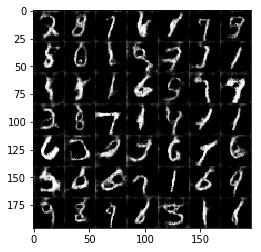

Epoch 2/2... Discriminator Loss: 1.1936... Generator Loss: 0.7305
Epoch 2/2... Discriminator Loss: 1.0401... Generator Loss: 1.3052
Epoch 2/2... Discriminator Loss: 1.0466... Generator Loss: 0.8604
Epoch 2/2... Discriminator Loss: 1.0077... Generator Loss: 1.3791
Epoch 2/2... Discriminator Loss: 1.7531... Generator Loss: 2.5182
Epoch 2/2... Discriminator Loss: 1.0075... Generator Loss: 1.7259
Epoch 2/2... Discriminator Loss: 0.9926... Generator Loss: 1.1879
Epoch 2/2... Discriminator Loss: 0.9024... Generator Loss: 1.2030
Epoch 2/2... Discriminator Loss: 0.8470... Generator Loss: 1.5460
Epoch 2/2... Discriminator Loss: 1.1085... Generator Loss: 0.7405


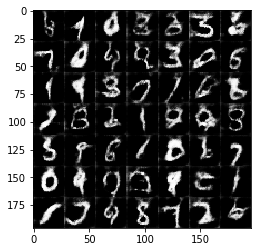

Epoch 2/2... Discriminator Loss: 1.5692... Generator Loss: 0.5840
Epoch 2/2... Discriminator Loss: 1.0542... Generator Loss: 1.5918
Epoch 2/2... Discriminator Loss: 0.8858... Generator Loss: 1.1121
Epoch 2/2... Discriminator Loss: 0.9203... Generator Loss: 1.2179
Epoch 2/2... Discriminator Loss: 1.2042... Generator Loss: 0.7802
Epoch 2/2... Discriminator Loss: 0.8066... Generator Loss: 1.4378
Epoch 2/2... Discriminator Loss: 1.1109... Generator Loss: 1.9864
Epoch 2/2... Discriminator Loss: 1.1998... Generator Loss: 0.7459
Epoch 2/2... Discriminator Loss: 1.0045... Generator Loss: 1.0291
Epoch 2/2... Discriminator Loss: 0.9212... Generator Loss: 1.0154


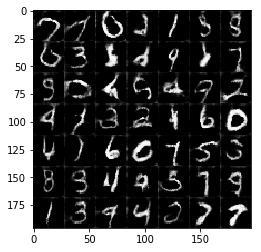

Epoch 2/2... Discriminator Loss: 0.8158... Generator Loss: 1.2576
Epoch 2/2... Discriminator Loss: 0.9686... Generator Loss: 1.3795
Epoch 2/2... Discriminator Loss: 0.7898... Generator Loss: 2.3872
Epoch 2/2... Discriminator Loss: 0.8002... Generator Loss: 2.0106
Epoch 2/2... Discriminator Loss: 2.3156... Generator Loss: 4.0952
Epoch 2/2... Discriminator Loss: 0.9709... Generator Loss: 1.5559
Epoch 2/2... Discriminator Loss: 0.9287... Generator Loss: 1.1217
Epoch 2/2... Discriminator Loss: 0.8521... Generator Loss: 1.5274
Epoch 2/2... Discriminator Loss: 3.8866... Generator Loss: 5.5698
Epoch 2/2... Discriminator Loss: 0.9834... Generator Loss: 1.8426


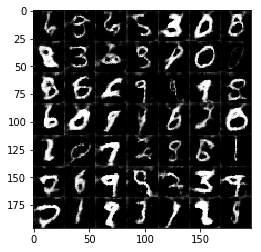

Epoch 2/2... Discriminator Loss: 1.1558... Generator Loss: 0.7493
Epoch 2/2... Discriminator Loss: 1.0831... Generator Loss: 0.9056
Epoch 2/2... Discriminator Loss: 1.6261... Generator Loss: 0.4461
Epoch 2/2... Discriminator Loss: 1.2864... Generator Loss: 2.1647
Epoch 2/2... Discriminator Loss: 1.0406... Generator Loss: 0.8902
Epoch 2/2... Discriminator Loss: 0.8862... Generator Loss: 1.4984
Epoch 2/2... Discriminator Loss: 1.1014... Generator Loss: 0.8005
Epoch 2/2... Discriminator Loss: 1.3942... Generator Loss: 0.5399
Epoch 2/2... Discriminator Loss: 1.7046... Generator Loss: 3.2245
Epoch 2/2... Discriminator Loss: 0.9684... Generator Loss: 0.9428


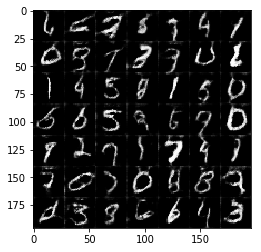

Epoch 2/2... Discriminator Loss: 0.9431... Generator Loss: 1.0800
Epoch 2/2... Discriminator Loss: 1.1514... Generator Loss: 0.7316
Epoch 2/2... Discriminator Loss: 1.3415... Generator Loss: 0.5956
Epoch 2/2... Discriminator Loss: 0.8523... Generator Loss: 1.2966
Epoch 2/2... Discriminator Loss: 1.6918... Generator Loss: 3.3409
Epoch 2/2... Discriminator Loss: 0.8329... Generator Loss: 1.3978
Epoch 2/2... Discriminator Loss: 1.3035... Generator Loss: 0.6342


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8577... Generator Loss: 3.3983
Epoch 1/1... Discriminator Loss: 1.6741... Generator Loss: 7.6564
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 1.2804
Epoch 1/1... Discriminator Loss: 0.9380... Generator Loss: 3.6708
Epoch 1/1... Discriminator Loss: 0.7916... Generator Loss: 2.9806
Epoch 1/1... Discriminator Loss: 0.5856... Generator Loss: 3.6284
Epoch 1/1... Discriminator Loss: 1.8814... Generator Loss: 0.3569
Epoch 1/1... Discriminator Loss: 0.6869... Generator Loss: 4.5863
Epoch 1/1... Discriminator Loss: 0.5585... Generator Loss: 2.1479
Epoch 1/1... Discriminator Loss: 0.6107... Generator Loss: 2.5939


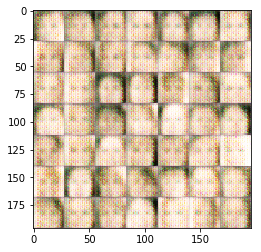

Epoch 1/1... Discriminator Loss: 2.6821... Generator Loss: 0.1548
Epoch 1/1... Discriminator Loss: 0.7717... Generator Loss: 3.1448
Epoch 1/1... Discriminator Loss: 0.4081... Generator Loss: 5.5751
Epoch 1/1... Discriminator Loss: 0.4618... Generator Loss: 5.0346
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.1244... Generator Loss: 0.9296
Epoch 1/1... Discriminator Loss: 0.4378... Generator Loss: 3.7362
Epoch 1/1... Discriminator Loss: 0.4940... Generator Loss: 2.3636
Epoch 1/1... Discriminator Loss: 1.8412... Generator Loss: 4.1454
Epoch 1/1... Discriminator Loss: 0.4100... Generator Loss: 4.6538


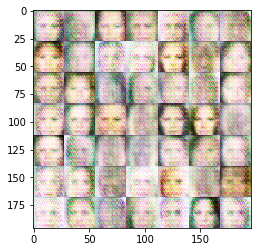

Epoch 1/1... Discriminator Loss: 0.5334... Generator Loss: 3.5224
Epoch 1/1... Discriminator Loss: 0.5003... Generator Loss: 3.3511
Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 0.5150... Generator Loss: 2.7931
Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 0.8554... Generator Loss: 1.0836
Epoch 1/1... Discriminator Loss: 1.0032... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 2.1959... Generator Loss: 0.2271
Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 0.9687
Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 4.3922


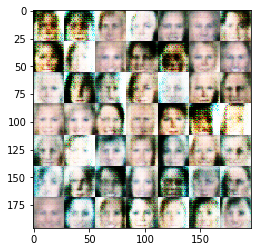

Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.4921
Epoch 1/1... Discriminator Loss: 0.9955... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.5534... Generator Loss: 5.8978
Epoch 1/1... Discriminator Loss: 0.8273... Generator Loss: 1.2434
Epoch 1/1... Discriminator Loss: 0.7204... Generator Loss: 2.3728
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 2.0372
Epoch 1/1... Discriminator Loss: 0.6925... Generator Loss: 2.1227
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 4.3716
Epoch 1/1... Discriminator Loss: 0.4841... Generator Loss: 3.0019


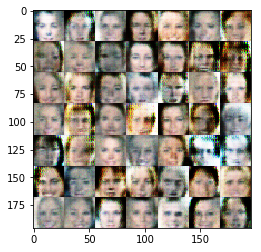

Epoch 1/1... Discriminator Loss: 0.8410... Generator Loss: 2.8096
Epoch 1/1... Discriminator Loss: 0.7634... Generator Loss: 1.3041
Epoch 1/1... Discriminator Loss: 1.6460... Generator Loss: 0.4022
Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 1.0562
Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 2.4554
Epoch 1/1... Discriminator Loss: 1.6707... Generator Loss: 0.3890
Epoch 1/1... Discriminator Loss: 0.7853... Generator Loss: 1.2432
Epoch 1/1... Discriminator Loss: 0.9007... Generator Loss: 0.9635
Epoch 1/1... Discriminator Loss: 1.1698... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 0.7997... Generator Loss: 1.9251


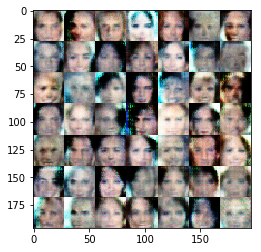

Epoch 1/1... Discriminator Loss: 1.0955... Generator Loss: 2.9217
Epoch 1/1... Discriminator Loss: 1.8141... Generator Loss: 2.4556
Epoch 1/1... Discriminator Loss: 0.5569... Generator Loss: 2.4919
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 1.8463
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 0.9226... Generator Loss: 0.9369
Epoch 1/1... Discriminator Loss: 0.9130... Generator Loss: 1.2411
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 0.7229... Generator Loss: 2.2766
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 1.3840


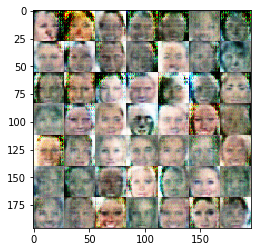

Epoch 1/1... Discriminator Loss: 0.9714... Generator Loss: 1.1566
Epoch 1/1... Discriminator Loss: 1.1591... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 0.7414... Generator Loss: 2.7248
Epoch 1/1... Discriminator Loss: 0.9403... Generator Loss: 1.8621
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 0.6291
Epoch 1/1... Discriminator Loss: 2.2776... Generator Loss: 0.1860
Epoch 1/1... Discriminator Loss: 1.2414... Generator Loss: 2.2535
Epoch 1/1... Discriminator Loss: 0.7807... Generator Loss: 1.6588
Epoch 1/1... Discriminator Loss: 1.1553... Generator Loss: 1.0817
Epoch 1/1... Discriminator Loss: 0.9353... Generator Loss: 1.0843


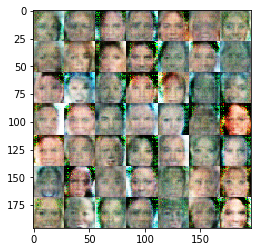

Epoch 1/1... Discriminator Loss: 0.6862... Generator Loss: 2.9310
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 1.0166
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 1.4912
Epoch 1/1... Discriminator Loss: 2.2341... Generator Loss: 2.3730
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 3.5969
Epoch 1/1... Discriminator Loss: 0.7949... Generator Loss: 1.4776
Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 1.0444
Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 1.6662
Epoch 1/1... Discriminator Loss: 0.7162... Generator Loss: 2.8530


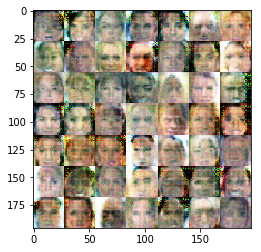

Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.9711
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 1.5713... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.8770
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.0195... Generator Loss: 1.3672
Epoch 1/1... Discriminator Loss: 1.1713... Generator Loss: 0.8975
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 0.6202


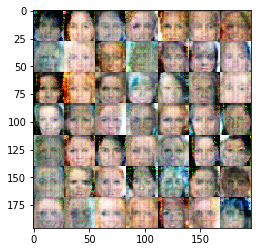

Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 1.5060
Epoch 1/1... Discriminator Loss: 0.8250... Generator Loss: 2.4027
Epoch 1/1... Discriminator Loss: 2.6367... Generator Loss: 4.2486
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 1.0751
Epoch 1/1... Discriminator Loss: 0.7610... Generator Loss: 2.7469
Epoch 1/1... Discriminator Loss: 1.1192... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 0.9791... Generator Loss: 1.0530
Epoch 1/1... Discriminator Loss: 2.0081... Generator Loss: 2.5110
Epoch 1/1... Discriminator Loss: 0.7966... Generator Loss: 1.5180


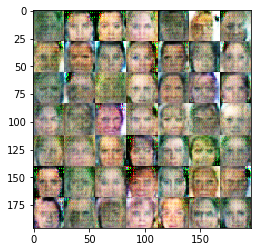

Epoch 1/1... Discriminator Loss: 0.9588... Generator Loss: 1.6879
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 0.7128... Generator Loss: 1.6103
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.5502
Epoch 1/1... Discriminator Loss: 0.8989... Generator Loss: 2.4413
Epoch 1/1... Discriminator Loss: 0.7512... Generator Loss: 1.7829
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 2.2038
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 3.1941
Epoch 1/1... Discriminator Loss: 1.2092... Generator Loss: 1.6819


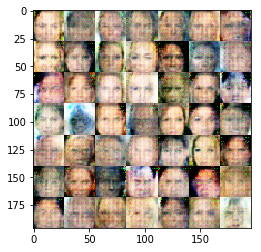

Epoch 1/1... Discriminator Loss: 0.6435... Generator Loss: 2.2604
Epoch 1/1... Discriminator Loss: 0.5465... Generator Loss: 1.8548
Epoch 1/1... Discriminator Loss: 3.1316... Generator Loss: 3.9782
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.0031... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 0.8648... Generator Loss: 1.7913
Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 1.7825
Epoch 1/1... Discriminator Loss: 0.9900... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 1.6355... Generator Loss: 0.3949
Epoch 1/1... Discriminator Loss: 0.7113... Generator Loss: 2.3793


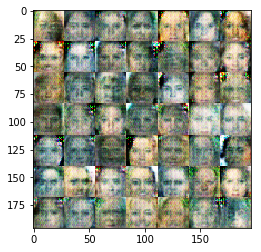

Epoch 1/1... Discriminator Loss: 0.9455... Generator Loss: 1.3590
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 1.9222
Epoch 1/1... Discriminator Loss: 0.9693... Generator Loss: 0.8988
Epoch 1/1... Discriminator Loss: 0.8286... Generator Loss: 1.4696
Epoch 1/1... Discriminator Loss: 0.5959... Generator Loss: 1.9030
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 0.9297
Epoch 1/1... Discriminator Loss: 0.6701... Generator Loss: 1.7143
Epoch 1/1... Discriminator Loss: 0.7299... Generator Loss: 1.8650
Epoch 1/1... Discriminator Loss: 0.9616... Generator Loss: 1.0462
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.9571


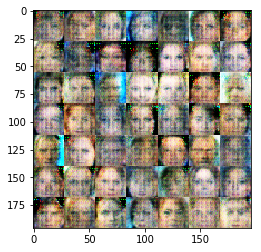

Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 3.3927
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 2.1703... Generator Loss: 2.8406
Epoch 1/1... Discriminator Loss: 1.0180... Generator Loss: 0.8580
Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 0.5469
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.5466
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.4617
Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 1.9726
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 0.9439
Epoch 1/1... Discriminator Loss: 0.6565... Generator Loss: 3.7783


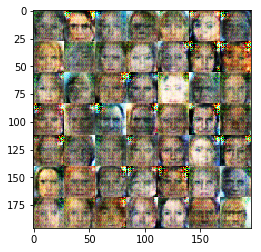

Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 0.7933... Generator Loss: 1.2118
Epoch 1/1... Discriminator Loss: 0.8040... Generator Loss: 1.2967
Epoch 1/1... Discriminator Loss: 1.7638... Generator Loss: 3.5997
Epoch 1/1... Discriminator Loss: 0.9382... Generator Loss: 0.9434
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 1.7254
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 1.4070
Epoch 1/1... Discriminator Loss: 0.7867... Generator Loss: 2.0937
Epoch 1/1... Discriminator Loss: 0.5095... Generator Loss: 2.4046
Epoch 1/1... Discriminator Loss: 0.7257... Generator Loss: 1.3781


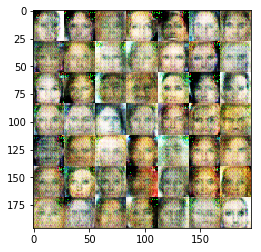

Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 2.5682
Epoch 1/1... Discriminator Loss: 0.8256... Generator Loss: 1.3800
Epoch 1/1... Discriminator Loss: 0.5765... Generator Loss: 1.9167
Epoch 1/1... Discriminator Loss: 0.8721... Generator Loss: 1.1468
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 0.7447... Generator Loss: 2.1516
Epoch 1/1... Discriminator Loss: 1.5989... Generator Loss: 0.3985
Epoch 1/1... Discriminator Loss: 0.7539... Generator Loss: 1.3302


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.